In [189]:
import numpy as np
import pandas as pd
import roman as roman
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, auc
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance, XGBRegressor
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
# from catboost import CatBoostClassifier
# from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, GridSearchCV
import math
from sklearn.linear_model import LinearRegression, LogisticRegression
import roman

In [3]:
warnings.filterwarnings("ignore")

In [346]:
data = pd.read_csv("train-2.csv")

In [347]:
data = data.drop_duplicates()

In [348]:
answer = list(set(data[data.TargetClass == 0].SpType.unique()) & set(data[data.TargetClass == 1].SpType.unique()))

In [349]:
answer

['G5V',
 'A2/A3III',
 'B1.5III-IVn',
 'F0/F2IVm...',
 'K1/K2V',
 'B3Vn...',
 'G6V',
 'G8/K0IV/V',
 'G9III-IV',
 'B2.5V',
 'B9:Vn...',
 'K3IV/V',
 'B9V+...',
 'G5III-IV',
 'B2V+...',
 'F6/F7V',
 'G6/8wF8IV/V',
 'K0IV:',
 'G7IV',
 'G8V',
 'A6III',
 'K0V',
 'G3V',
 'F0III:',
 'B3III',
 'O9.5Ia SB:',
 'B7Iab...',
 'K2/K3V',
 'B2III-IV',
 'A3II/IIIm..',
 'A6:III:+...',
 'G8III/IV',
 'F9III',
 'K0IV/VCNIII',
 'A2V+...',
 'A3III + K1:',
 'B0IVpe',
 'A4/A5III:',
 'B5Ia',
 'G8IVp',
 'A3Vs',
 'K1IVCN...',
 'A(V) + G5III',
 'B6III',
 'K0:III+...',
 'A2II/III',
 'K0VCN...',
 'K1IV...',
 'B4II/III',
 'K1/2III: +F',
 'G9IV',
 'B6/B7II',
 'G6/G8III/IV',
 'F8III/IV',
 'B9IIp...',
 'B0Ib/II',
 'G8IV',
 'B8II',
 'K3III+A0IV/V',
 'G6IV/V',
 'K7V',
 'G9V',
 'F4IIIvar',
 'B7Ib',
 'G4V:p',
 'F3IVp...',
 'A8III',
 'B7Ib/II',
 'B8Ia-Iab',
 'G8IV...',
 'G6IV',
 'A3II/III',
 'G3IV/V',
 'F3V:+...',
 'B7II',
 'F0IIw...',
 'K0/K1IVwp..',
 'B6II/III',
 'G3/G5Vw',
 'B5Vn...',
 'K0IVw...',
 'K1IV/V',
 'B4II',
 'K3III

In [350]:
data = data[~data.SpType.isin(answer)]

In [351]:
color_index = lambda x: 4600 * ((1 / (0.92 * x + 1.7)) + (1 / (0.92 * x + 0.62)))
round_ = lambda x: round(x, 1)
def transform_type2(x):
    x1 = x
    x1 = x1.replace('I', '')
    x1 = x1.replace('V', '')
    lst = list(set(x1))
    for i in lst:
        x = x.replace(i, ' ')
    x = x.split()[-1]
    return roman.fromRoman(x) * 1000
transform_type = lambda x: 1 if "V" in x or "VI" in x or "VII" in x else -1
# avag =

In [352]:
Ms = 3.86 * 10 ** 33
data["temp"] = data["B-V"].apply(color_index)
# data["R"] = np.sqrt(data.Vmag) / np.power(data.temp / 5778, 2)
# data["M"] = data.Vmag + 5 - (5 * np.log(data.Plx))
# data["L"] = np.power(data.R, 2) * np.power(data.temp / 5778, 4)

In [353]:
# data.M.min()

In [354]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp
1,4.334196,2.198947,0.593309,1.153210,G2Ib,13.043324,0,4402.632871
2,7.873019,11.750465,0.616568,0.589166,F5V,17.736492,1,6010.288989
3,8.110014,2.143815,0.848508,1.322107,K2III,15.592469,0,4082.305608
4,8.025193,4.165622,0.899296,1.141646,K5III,16.379680,0,4426.508743
5,2.899130,11.110086,0.701719,1.095357,M0III,14.370388,0,4524.866088


In [355]:
# data["spt2"] = data.SpType.apply(transform_type2)
data.SpType = data.SpType.apply(transform_type)

In [356]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp
1,4.334196,2.198947,0.593309,1.153210,-1,13.043324,0,4402.632871
2,7.873019,11.750465,0.616568,0.589166,1,17.736492,1,6010.288989
3,8.110014,2.143815,0.848508,1.322107,-1,15.592469,0,4082.305608
4,8.025193,4.165622,0.899296,1.141646,-1,16.379680,0,4426.508743
5,2.899130,11.110086,0.701719,1.095357,-1,14.370388,0,4524.866088


In [357]:
data = data[data.Plx + data.e_Plx > 0]

In [358]:
# plt.boxplot(data.Vmag)

In [359]:
# data = data[(data.Vmag > 4) & (data.Vmag < 11)]

In [360]:
# plt.boxplot(data["B-V"])

In [361]:
# data = data[data["B-V"] < 23]

In [362]:
# plt.boxplot(data.Amag)

In [363]:
# data = data[(data.Amag < 22) & (data.Amag > 10)]

In [364]:
# data.Amag = data.Amag.apply(round_)
# data.Vmag = data.Vmag.apply(round_)
# data.Plx = data.Plx.apply(round_)
# data.e_Plx = data.e_Plx.apply(round_)
# data["B-V"] = data["B-V"].apply(round_)
# data.temp = data.temp.apply(round_)
# model["BVtype"] = round(model["B-V"] * model.SpType)

In [365]:
# data = data.drop( ["e_Plx"], axis=1)
# data[:] = MinMaxScaler().fit_transform(data)

In [366]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp
1,4.334196,2.198947,0.593309,1.153210,-1,13.043324,0,4402.632871
2,7.873019,11.750465,0.616568,0.589166,1,17.736492,1,6010.288989
3,8.110014,2.143815,0.848508,1.322107,-1,15.592469,0,4082.305608
4,8.025193,4.165622,0.899296,1.141646,-1,16.379680,0,4426.508743
5,2.899130,11.110086,0.701719,1.095357,-1,14.370388,0,4524.866088


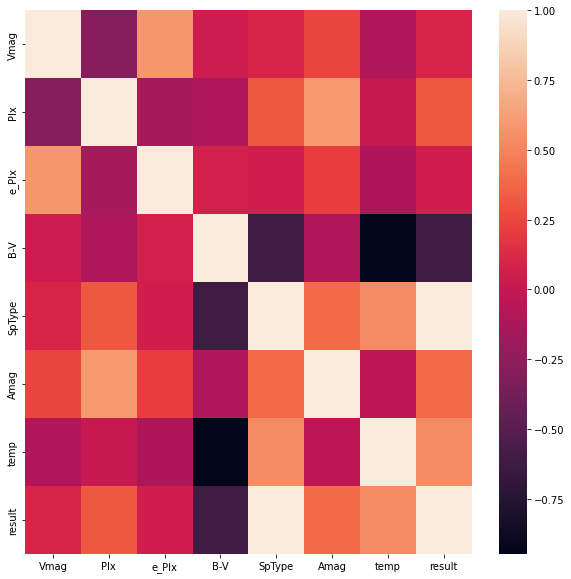

In [367]:
y = data['TargetClass']
X = data.drop(columns=['TargetClass'])
# X = data[["temp", "Amag", "SpType"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=5, test_size=0.2)

fig = plt.figure(figsize=(10, 10))
X_test2 = X_test.copy()
X_test2["result"] = y_test
data_ploting = X_test2.corr(method='pearson')
sns.heatmap(data_ploting, linecolor='black')
plt.show()

In [368]:
data.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass,temp
1,4.334196,2.198947,0.593309,1.153210,-1,13.043324,0,4402.632871
2,7.873019,11.750465,0.616568,0.589166,1,17.736492,1,6010.288989
3,8.110014,2.143815,0.848508,1.322107,-1,15.592469,0,4082.305608
4,8.025193,4.165622,0.899296,1.141646,-1,16.379680,0,4426.508743
5,2.899130,11.110086,0.701719,1.095357,-1,14.370388,0,4524.866088


In [369]:
model2 = LinearRegression()
model2.fit(X, y)

LinearRegression()

In [370]:
model3 = LogisticRegression()
model3.fit(X, y)

LogisticRegression()

In [371]:
%%time
# xgb = XGBClassifier(subsample=0.8,
#                     min_child_weight=1,
#                     max_depth=14,
#                     gamma=1,
#                     colsample_bytree=0.8)
xgb = GradientBoostingRegressor()
xgb.fit(X_train, y_train)

CPU times: user 3.15 s, sys: 16.6 ms, total: 3.16 s
Wall time: 3.23 s


GradientBoostingRegressor()

In [372]:
pred = xgb.predict(X_test)
pred_ = pd.Series(model2.predict(X_test))
pred__ = pd.Series(model3.predict(X_test))

In [373]:
pred__.head()

0    0
1    0
2    1
3    1
4    1
dtype: int64

In [374]:
roc_auc_score(y_test, pred), roc_auc_score(y_test, pred_), roc_auc_score(y_test, pred__)

(0.9999901940595612, 0.9999298174834315, 0.999801429706116)

In [375]:
0.9999901940595612

0.9999901940595612

In [124]:
def check(M):
    if M > 0:
        return 1
    else:
        return 0


In [196]:
data_ = pd.read_csv("predict.csv")

In [197]:
data_test = data_.copy()

In [198]:
Ms = 3.86 * 10 ** 33
data_test["temp"] = data_test["B-V"].apply(color_index)
# data_test["R"] = np.sqrt(data_test.Vmag) / np.power(data_test.temp / 5778, 2)
# data_test["M"] = data_test.Vmag + 5 - (5 * np.log(data_test.Plx))
# data_test["L"] = np.power(data_test.R, 2) * np.power(data_test.temp / 5778, 4)

In [199]:
list(data.columns) == list(data_test.columns)

False

In [200]:
data.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'TargetClass', 'temp'], dtype='object')

In [201]:
data_test.columns

Index(['Vmag', 'Plx', 'e_Plx', 'B-V', 'SpType', 'Amag', 'temp'], dtype='object')

In [202]:
data_test.head()

,Vmag,Plx,e_Plx,B-V,SpType,Amag,temp
0,4.039519,13.596504,0.845101,-0.097823,F5V+...,15.774122,11536.343340
1,6.655719,4.010332,1.050017,1.386670,K5III,15.344976,3972.332732
2,6.405060,0.348855,0.961598,0.951503,B0IVpe,12.236103,4862.277063
3,9.113068,2.954461,1.251422,1.002819,K1III,15.560838,4735.981168
4,6.107686,3.144180,0.475795,0.493345,G8II-IIIvar,12.771981,6419.225528


In [203]:
data_test.SpType = data_test.SpType.apply(transform_type)

In [204]:
data_test[:] = MinMaxScaler().fit_transform(data_test)

In [205]:
type(data_test)

pandas.core.frame.DataFrame

In [206]:
pred = xgb.predict(data_test.values)

In [207]:
# pred =[check(i) for i in data_test.M]

In [208]:
data_["TargetClass"] = pred

In [209]:
data_

,Vmag,Plx,e_Plx,B-V,SpType,Amag,TargetClass
0,4.039519,13.596504,0.845101,-0.097823,F5V+...,15.774122,0.209362
1,6.655719,4.010332,1.050017,1.386670,K5III,15.344976,0.069348
2,6.405060,0.348855,0.961598,0.951503,B0IVpe,12.236103,0.209282
3,9.113068,2.954461,1.251422,1.002819,K1III,15.560838,0.069348
4,6.107686,3.144180,0.475795,0.493345,G8II-IIIvar,12.771981,0.069348
...,...,...,...,...,...,...,...
7906,8.255272,2.858885,0.822289,1.349195,M3III,16.438014,0.069348
7907,6.255358,3.034436,0.449386,0.966053,K0III,13.898403,0.069348
7908,8.643598,10.932145,0.947897,0.504383,G0V,18.980729,0.209282
7909,9.400810,6.279361,1.332124,0.351073,F2V,16.872491,0.209282


In [210]:
data_.to_csv("answer.csv")